# Read dataset

## Download dataset

In [1]:
# !curl -O https://cf.10xgenomics.com/samples/cell-vdj/7.0.1/SC5v2_GEX_Breast_Cancer_DTC_Aggr/SC5v2_GEX_Breast_Cancer_DTC_Aggr_count_filtered_feature_bc_matrix.h5
# !curl -O https://cf.10xgenomics.com/samples/cell-exp/7.0.1/SC3pv3_GEX_Breast_Cancer_DTC_Aggr/SC3pv3_GEX_Breast_Cancer_DTC_Aggr_count_filtered_feature_bc_matrix.h5
# !curl -O https://cf.10xgenomics.com/samples/cell-exp/7.0.1/Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer/Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer_count_sample_filtered_feature_bc_matrix.h5


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  114M  100  114M    0     0  9931k      0  0:00:11  0:00:11 --:--:-- 14.8M00:19  0:00:08  0:00:11  177k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48.1M  100 48.1M    0     0  77.3M      0 --:--:-- --:--:-- --:--:-- 77.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87.3M  100 87.3M    0     0  12.6M      0  0:00:06  0:00:06 --:--:-- 15.7M


In [2]:
import scanpy as sc
import pandas as pd

xenium_df = sc.read_10x_h5("Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer_count_sample_filtered_feature_bc_matrix.h5")
sc1 = sc.read_10x_h5("SC3pv3_GEX_Breast_Cancer_DTC_Aggr_count_filtered_feature_bc_matrix.h5")
sc2 = sc.read_10x_h5("SC5v2_GEX_Breast_Cancer_DTC_Aggr_count_filtered_feature_bc_matrix.h5")
adatas = [xenium_df, sc1, sc2]

/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Varia

In [3]:
xenium_df

AnnData object with n_obs × n_vars = 30365 × 18082
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
sc1

AnnData object with n_obs × n_vars = 12388 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
sc2

AnnData object with n_obs × n_vars = 22969 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Preprocessing

In [6]:
for adata in adatas:
  adata.var_names_make_unique()
  sc.pp.log1p(adata)
  sc.pp.normalize_total(adata)
  sc.pp.pca(adata)


# Find the matches by MNN

In [8]:
# !pip install fbpca
# !pip install annoy
# !pip install intervaltree

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:
import torch
import operator
import numpy as np
import scanpy as sc
from fbpca import pca
from annoy import AnnoyIndex
from intervaltree import IntervalTree
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, vstack


In [8]:
# Default parameters.
ALPHA = 0.10
APPROX = True
KNN = 10
VERBOSE = 2

# Exact nearest neighbors search.
def nn(ds1, ds2, knn=KNN, metric_p=2):
    # Find nearest neighbors of first dataset.
    nn_ = NearestNeighbors(knn, p=metric_p)
    nn_.fit(ds2)
    ind = nn_.kneighbors(ds1, return_distance=False)

    match = set()
    for a, b in zip(range(ds1.shape[0]), ind):
        for b_i in b:
            match.add((a, b_i))
    print("Find the matches")
    return match

# Approximate nearest neighbors using locality sensitive hashing.
def nn_approx(ds1, ds2, knn=KNN, metric='manhattan', n_trees=10):
    # Build index.
    a = AnnoyIndex(ds2.shape[1], metric=metric) # The distance can be "angular", "euclidean", "manhattan", "hamming", or "dot".
    for i in range(ds2.shape[0]):
        a.add_item(i, ds2[i, :])
    a.build(n_trees, n_jobs=-1)

    # Search index.
    ind = []
    for i in range(ds1.shape[0]):
        ind.append(a.get_nns_by_vector(ds1[i, :], knn, search_k=-1))
    ind = np.array(ind)

    # Match.
    match = set()
    for a, b in zip(range(ds1.shape[0]), ind):
        for b_i in b:
            match.add((a, b_i))
    print("Find the matches")
    return match

# Populate a table (in place) that stores mutual nearest neighbors
# between datasets.
def fill_table(table, i, curr_ds, datasets, base_ds=0, knn=KNN, approx=APPROX, ):
    # Concat reference dataset
    curr_ref = np.concatenate(datasets)
    if approx:
        match = nn_approx(curr_ds, curr_ref, knn=knn)
    else:
        match = nn(curr_ds, curr_ref, knn=knn, metric_p=1)

    # Build interval tree.
    itree_ds_idx = IntervalTree()
    itree_pos_base = IntervalTree()
    pos = 0
    for j in range(len(datasets)):
        n_cells = datasets[j].shape[0]
        itree_ds_idx[pos:(pos + n_cells)] = base_ds + j
        itree_pos_base[pos:(pos + n_cells)] = pos
        pos += n_cells

    # Store all mutual nearest neighbors between datasets.
    for d, r in match:
        interval = itree_ds_idx[r]
        assert(len(interval) == 1)
        j = interval.pop().data
        interval = itree_pos_base[r]
        assert(len(interval) == 1)
        base = interval.pop().data
        if not (i, j) in table:
            table[(i, j)] = set()
        table[(i, j)].add((d, r - base))
        assert(r - base >= 0)
    print("Fill the table")

# Fill table of alignment scores.
def find_alignments_table(datasets, knn=KNN, approx=APPROX, verbose=VERBOSE, prenormalized=False):
    if not prenormalized:
        datasets = [ normalize(ds, axis=1) for ds in datasets ]

    table = {}
    for i in range(len(datasets)):
        if len(datasets[:i]) > 0:
            fill_table(table, i, datasets[i], datasets[:i], knn=knn,
                       approx=approx)
        if len(datasets[i+1:]) > 0:
            fill_table(table, i, datasets[i], datasets[i+1:],
                       knn=knn, base_ds=i+1, approx=approx)

    # Count all mutual nearest neighbors between datasets.
    matches = {}
    table1 = {}
    if verbose > 1:
        table_print = np.zeros((len(datasets), len(datasets)))
    for i in range(len(datasets)):
        for j in range(len(datasets)):
            if i >= j:
                continue
            if not (i, j) in table or not (j, i) in table:
                continue
            match_ij = table[(i, j)]
            match_ji = set([ (b, a) for a, b in table[(j, i)] ])
            matches[(i, j)] = match_ij & match_ji

            table1[(i, j)] = (max(
                float(len(set([ idx for idx, _ in matches[(i, j)] ]))) /
                datasets[i].shape[0],
                float(len(set([ idx for _, idx in matches[(i, j)] ]))) /
                datasets[j].shape[0]
            ))
            if verbose > 1:
                table_print[i, j] += table1[(i, j)]

    if verbose > 1:
        print(table_print)
        return table1, table_print, matches
    else:
        return table1, None, matches

# Find the matching pairs of cells between datasets.
def find_alignments(datasets, knn=KNN, approx=APPROX, verbose=VERBOSE, alpha=ALPHA, prenormalized=False):
    table1, _, matches = find_alignments_table(
        datasets, knn=knn, approx=approx, verbose=verbose,
        prenormalized=prenormalized,
    )

    alignments = [ (i, j) for (i, j), val in reversed(
        sorted(table1.items(), key=operator.itemgetter(1))
    ) if val > alpha ]

    return alignments, matches

## Display the matched table

In [9]:
# Default parameters.
# ALPHA is the threshold for the correlation score, the score of matached cell pairs will keep if value is greater than ALPHA
# APPROX to control whether using KNN, KNN = 1 if APPROX = False.

ALPHA = 0.05
APPROX = True
KNN = 20
VERBOSE = 2

datasets_pca = [adata.copy().obsm['X_pca'] for adata in adatas]
# datasets = [adata.X.toarray() for adata in adatas]

# Find MNN
# Input data can be the raw data or processed data such as pca
alignments, matches = find_alignments(datasets_pca, knn=KNN, approx=APPROX, verbose=VERBOSE, alpha=ALPHA)
match = []
for i, j in alignments:
    base_i, base_j = 0, 0
    for k in range(i):
        base_i += adatas[k].shape[0]
    for k in range(j):
        base_j += adatas[k].shape[0]
    match.extend([ (a + base_i, b + base_j) for a, b in matches[(i, j)] ])
match = np.array([[a,b] for a, b in match])


Find the matches
Fill the table
Find the matches
Fill the table
Find the matches
Fill the table
Find the matches
Fill the table
[[0.         0.08475944 0.03204347]
 [0.         0.         0.2208589 ]
 [0.         0.         0.        ]]


In [10]:
# Display the matched table
# cur_ds is Xenium dataset
# ref_ds is concatenation of Xenium and SC dataset
match_tbl = pd.DataFrame(match)
match_tbl.columns = ["cur_ds", "ref_ds"]
match_tbl = match_tbl[match_tbl['cur_ds']<=adatas[0].shape[0]]
match_tbl

,cur_ds,ref_ds
9106,12890,38694
9107,3843,40895
9108,11219,31586
9109,22126,34113
9110,2938,31520
...,...,...
12718,2506,37749
12719,29781,31795
12720,9762,34000
12721,10085,42238


In [13]:
# Construct a new adata from Xenium data and SC data
# We extract gene expression from SC data, but keep the attribute of Xenium dataset(Xenium adata.obs).
import anndata as ad
cur_adata = xenium_df
ref_adata = ad.concat([xenium_df, sc1, sc2])
ref_adata.obs_names_make_unique()
ref_adata

/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 65722 × 18082
    obsm: 'X_pca'

In [16]:
new_adata = ref_adata.to_df().iloc[match_tbl.ref_ds, :]
new_obs = cur_adata.obs.iloc[match_tbl.cur_ds,:]

In [32]:
new_adata = ad.AnnData(new_adata)
new_adata.obs = new_obs
new_adata.obs_names_make_unique()
sc.pp.calculate_qc_metrics(new_adata, inplace=True)
new_adata

/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 3617 × 18082
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

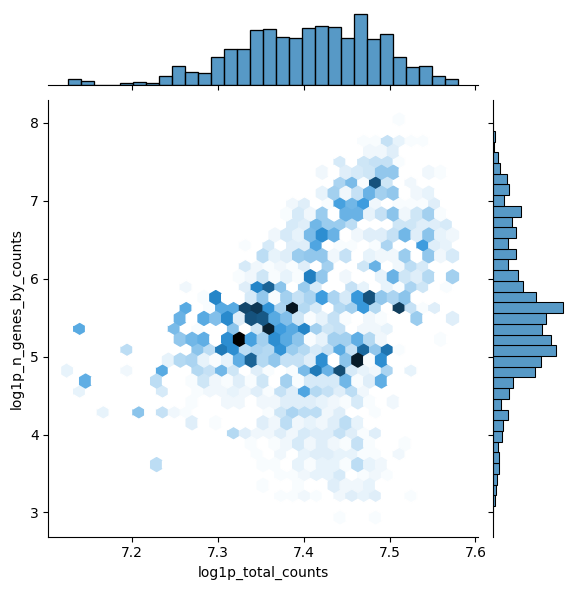

In [33]:
import seaborn as sns
sns.jointplot(
    data=new_adata.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)


In [34]:
new_adata

AnnData object with n_obs × n_vars = 3617 × 18082
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

# Reference

[1] MNN algorithm is modified from https://github.com/zoubin-ai/deepMNN/blob/main/deepMNN/deep_batch_correction.py
